In [1]:
from matplotlib import pyplot as plt
import matplotlib 
%matplotlib inline
import pandas as pd
# import gdal
import os
import datetime
from datetime import timedelta
import numpy as np
# import fiona
import shapely
from shapely import geometry
from os.path import dirname
import glob
import seaborn
import sys
import pickle
from functools import partial
import seaborn as sns
parent_dir = dirname(dirname(os.getcwd()))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','lib'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','4_temperature'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','3_channel_routing'))
from temperature import SimpleTemperature, LagrangianSimpleTemperature, EulerianWesthoff, LaxWendroffWesthoff
from channel import SimpleChannel
# import zonal_stats as zs
import meteolib as meteo
import evaplib as evap

In [2]:
try:
    basins = glob.glob(os.path.join(parent_dir,'raw_data','basins_poly','*.shp'))[0]
except RuntimeError:
    print 'Cannot find basins shapefile. Please make sure basins shapefile is located in \n the model directory under /raw_data/basins_poly'

In [3]:
rew_config = pickle.load( open( os.path.join(parent_dir,'model_data','rew_config.p'), "rb" ) )
climate_group_forcing = pickle.load( open( os.path.join(parent_dir,'model_data','climate_group_forcing.p'), "rb" ) )
model_config = pickle.load( open( os.path.join(parent_dir, 'model_data', 'model_config.p'), 'rb'))
temperature_params = pickle.load( open( os.path.join(parent_dir, 'model_data', 'temperature_params.p'), 'rb'))
hill_groups = pickle.load( open( os.path.join(parent_dir,'model_data','solved_hillslope_discharge.p'), "rb" ) )
solved_channel_routing = pickle.load( open( os.path.join(parent_dir,'model_data','solved_channel_routing.p'), "rb" ) )
channel_params = pickle.load( open( os.path.join(parent_dir,'model_data','channel_params.p'), "rb" ))
radiation = pickle.load( open(os.path.join(parent_dir, 'raw_data', 'radiation', 'radiation.p'),'rb') )
ta_ea = pickle.load( open(os.path.join(parent_dir, 'raw_data', 'ta_ea', 'ta_ea.p'),'rb') )

#start/stop dates for running model  
#spinup date is the date after start_date for which we assume model is finished spinning up         
start_date = model_config['start_date']
stop_date = model_config['stop_date']
spinup_date = model_config['spinup_date']
Tmax = model_config['Tmax']
dt = model_config['dt_temperature']
resample_freq_channel = model_config['resample_freq_channel']
resample_freq_hillslope = model_config['resample_freq_hillslope']
resample_freq_temperature = model_config['resample_freq_temperature']

# dt = (5./60.)/1440.
# resample_freq_temperature = '5S'
# for rew_id in rew_config.keys(): 
#     args['model'] = LaxWendroffWesthoff   
    
t = np.linspace(0,Tmax,np.ceil(Tmax/dt)+1)
timestamps_hillslope = pd.date_range(start_date, stop_date, freq=resample_freq_hillslope)
timestamps_channel = pd.date_range(start_date, stop_date, freq=resample_freq_channel)
timestamps_temperature = pd.date_range(start_date, stop_date, freq=resample_freq_temperature)

In [4]:
channel_network = {}
for rew_id in rew_config.keys(): 
    args = rew_config[rew_id].copy()
    args.update(channel_params[rew_id])
    channel_network[rew_id] = args['model'](rew_id=rew_id, **args)

temperature_network = {}
for rew_id in rew_config.keys(): 
    args = rew_config[rew_id].copy()
    args.update(temperature_params[rew_id])
    temperature_network[rew_id] = args['model'](rew_id=rew_id, **args)

In [5]:
#Find REW with largest total contributing area
outlet_id = rew_config.keys()[0]
area_max = rew_config[outlet_id]['upstream_area']
for rew_id in rew_config.keys():
    if rew_config[rew_id]['upstream_area']>area_max:
        outlet_id = rew_id

rew_ids = rew_config.keys()
shreves = [rew_config[rew_id]['shreve'] for rew_id in rew_ids]
rewQueue = [rew_id for (shreve,rew_id) in sorted(zip(shreves,rew_ids))]
network_temps = {}
network_airtemp = {}
fluxes = {}

print "Solve REWs in this order:"
print(rewQueue)

for rew_id in rewQueue[:1]:
    
    print 'Working on REW ' + str(rew_id)
    shreve  = rew_config[rew_id]['shreve']
    group_id = rew_config[rew_id]['group']
    climate_group_id = group_id[1]
    rew_df = climate_group_forcing[climate_group_id]
    width = channel_network[rew_id].width
    length = channel_network[rew_id].length
    
    Lin = np.array(radiation[rew_id]['Lin'][start_date:stop_date].resample(resample_freq_temperature).interpolate())
    Sin = np.array(radiation[rew_id]['Sin'][start_date:stop_date].resample(resample_freq_temperature).interpolate())
    
    temp_ea = ta_ea[rew_id].resample(resample_freq_temperature).interpolate()
    ppt_daily = climate_group_forcing[climate_group_id][start_date:stop_date].ppt
    ppt = np.array(climate_group_forcing[climate_group_id][start_date:stop_date].ppt.resample(resample_freq_temperature).ffill())
    ta = np.array(temp_ea['ta'][start_date:stop_date])
    ea = np.array(temp_ea['ea'][start_date:stop_date])
    hillslope_discharge = pd.DataFrame({'discharge':hill_groups[group_id]['discharge']}, index=hill_groups[group_id].index)
    hillslope_overlandFlow = pd.DataFrame({'overlandFlow':hill_groups[group_id]['overlandFlow']}, index=hill_groups[group_id].index)
    
    hillslope_volumetric_overlandFlow = np.array(hillslope_overlandFlow[start_date:stop_date].overlandFlow.resample(resample_freq_temperature).ffill())*rew_config[rew_id]['area_sqcm']
    hillslope_volumetric_discharge = np.array(hillslope_discharge[start_date:stop_date].discharge.resample(resample_freq_temperature).ffill())*rew_config[rew_id]['area_sqcm']
    
    volumetric_discharge = np.array(solved_channel_routing[rew_id][start_date:stop_date].volumetric_discharge.resample(resample_freq_temperature).ffill())
    temp = np.zeros(np.shape(t))
    
    #get upstream discharges, upstream temperatures
    if shreve == 1:
        vol_1 = np.zeros(np.shape(t))
        vol_2 = np.zeros(np.shape(t))

        temp_1 = np.zeros(np.shape(t))
        temp_2 = np.zeros(np.shape(t))
    else:
        upstream_1 = rew_config[rew_id]['prev_str01']
        upstream_2 = rew_config[rew_id]['prev_str02']

        vol_1 = np.array(solved_channel_routing[upstream_1][start_date:stop_date].volumetric_discharge.resample(resample_freq_temperature).ffill())
        vol_2 = np.array(solved_channel_routing[upstream_2][start_date:stop_date].volumetric_discharge.resample(resample_freq_temperature).ffill())
        
        temp_1 = np.array(network_temps[upstream_1].temperature)
        temp_2 = np.array(network_temps[upstream_2].temperature)

    # Now get volumes in channel link. 
    volume = np.array(solved_channel_routing[rew_id][start_date:stop_date].volumes.resample(resample_freq_temperature).interpolate())
    start_temp_model = int(1/dt*(len(pd.date_range(start_date,spinup_date))-365))
    fluxRows = []
    count = 0
    for i in range(len(t)):
        if i<start_temp_model:
            temp[i] = temperature_network[rew_id].temperature
            fluxRows.append([])
        else:
#             if timestamps_temperature[i].month in [11,12,1,2,3]: H = 99
#             else: H= 75
    
            varyArgs = ['vol_1','temp_1','vol_2','temp_2','hillslope_volumetric_discharge', 'hillslope_volumetric_overlandFlow', 'volumetric_discharge', 'volume', 'ta', 'Lin', 'Sin', 'ppt', 'ea']
            constArgs = ['width','length']

            tempArgs = {}
            for arg in varyArgs: tempArgs[arg] = globals()[arg][i]
            for arg in constArgs: tempArgs[arg] = globals()[arg]

            temp[i]=temperature_network[rew_id].temperature
            f = temperature_network[rew_id].update(dt, **tempArgs)
            fluxRows.append([f[key] for key in f.keys()])
        
            count += 1
        
#         if count > 100: break
    
    fluxes[rew_id] = pd.DataFrame(fluxRows,columns=f.keys(),index=timestamps_temperature)
    
            
    depth = volume/(length*width)
    network_airtemp[rew_id] = pd.DataFrame({'ta':ta, 'ppt':ppt, 'volume':volume, 'depth':depth, 'Sin':Sin}, index=timestamps_temperature)
    network_temps[rew_id] = pd.DataFrame({'temperature':temp},index=timestamps_temperature)

Solve REWs in this order:
[1, 2, 3]
Working on REW 1


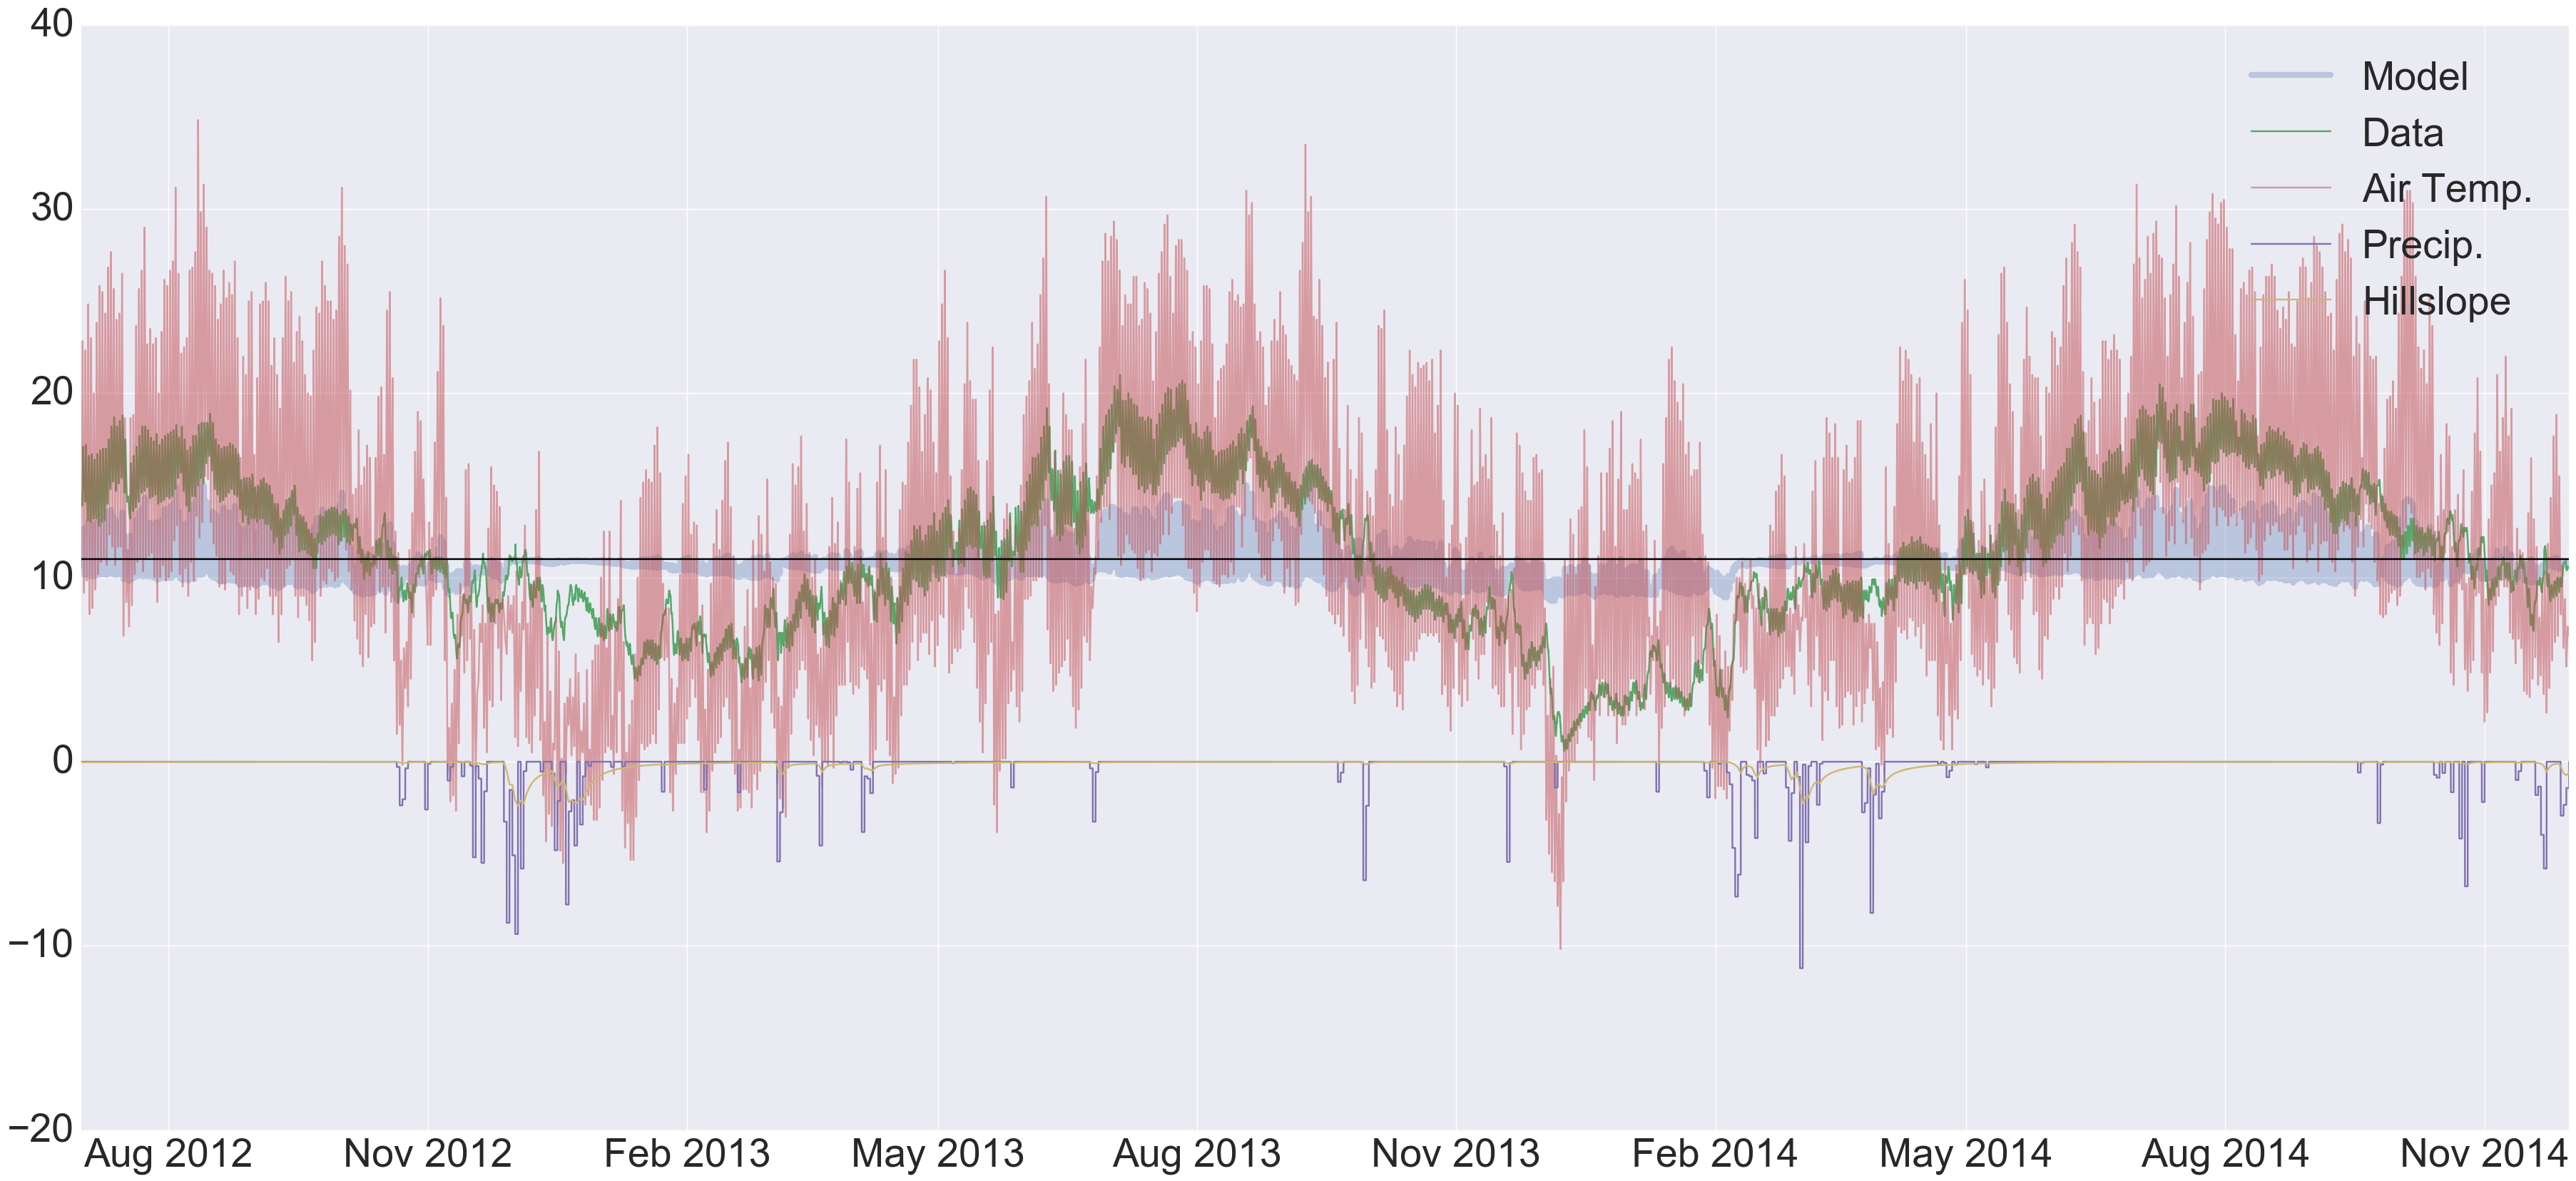

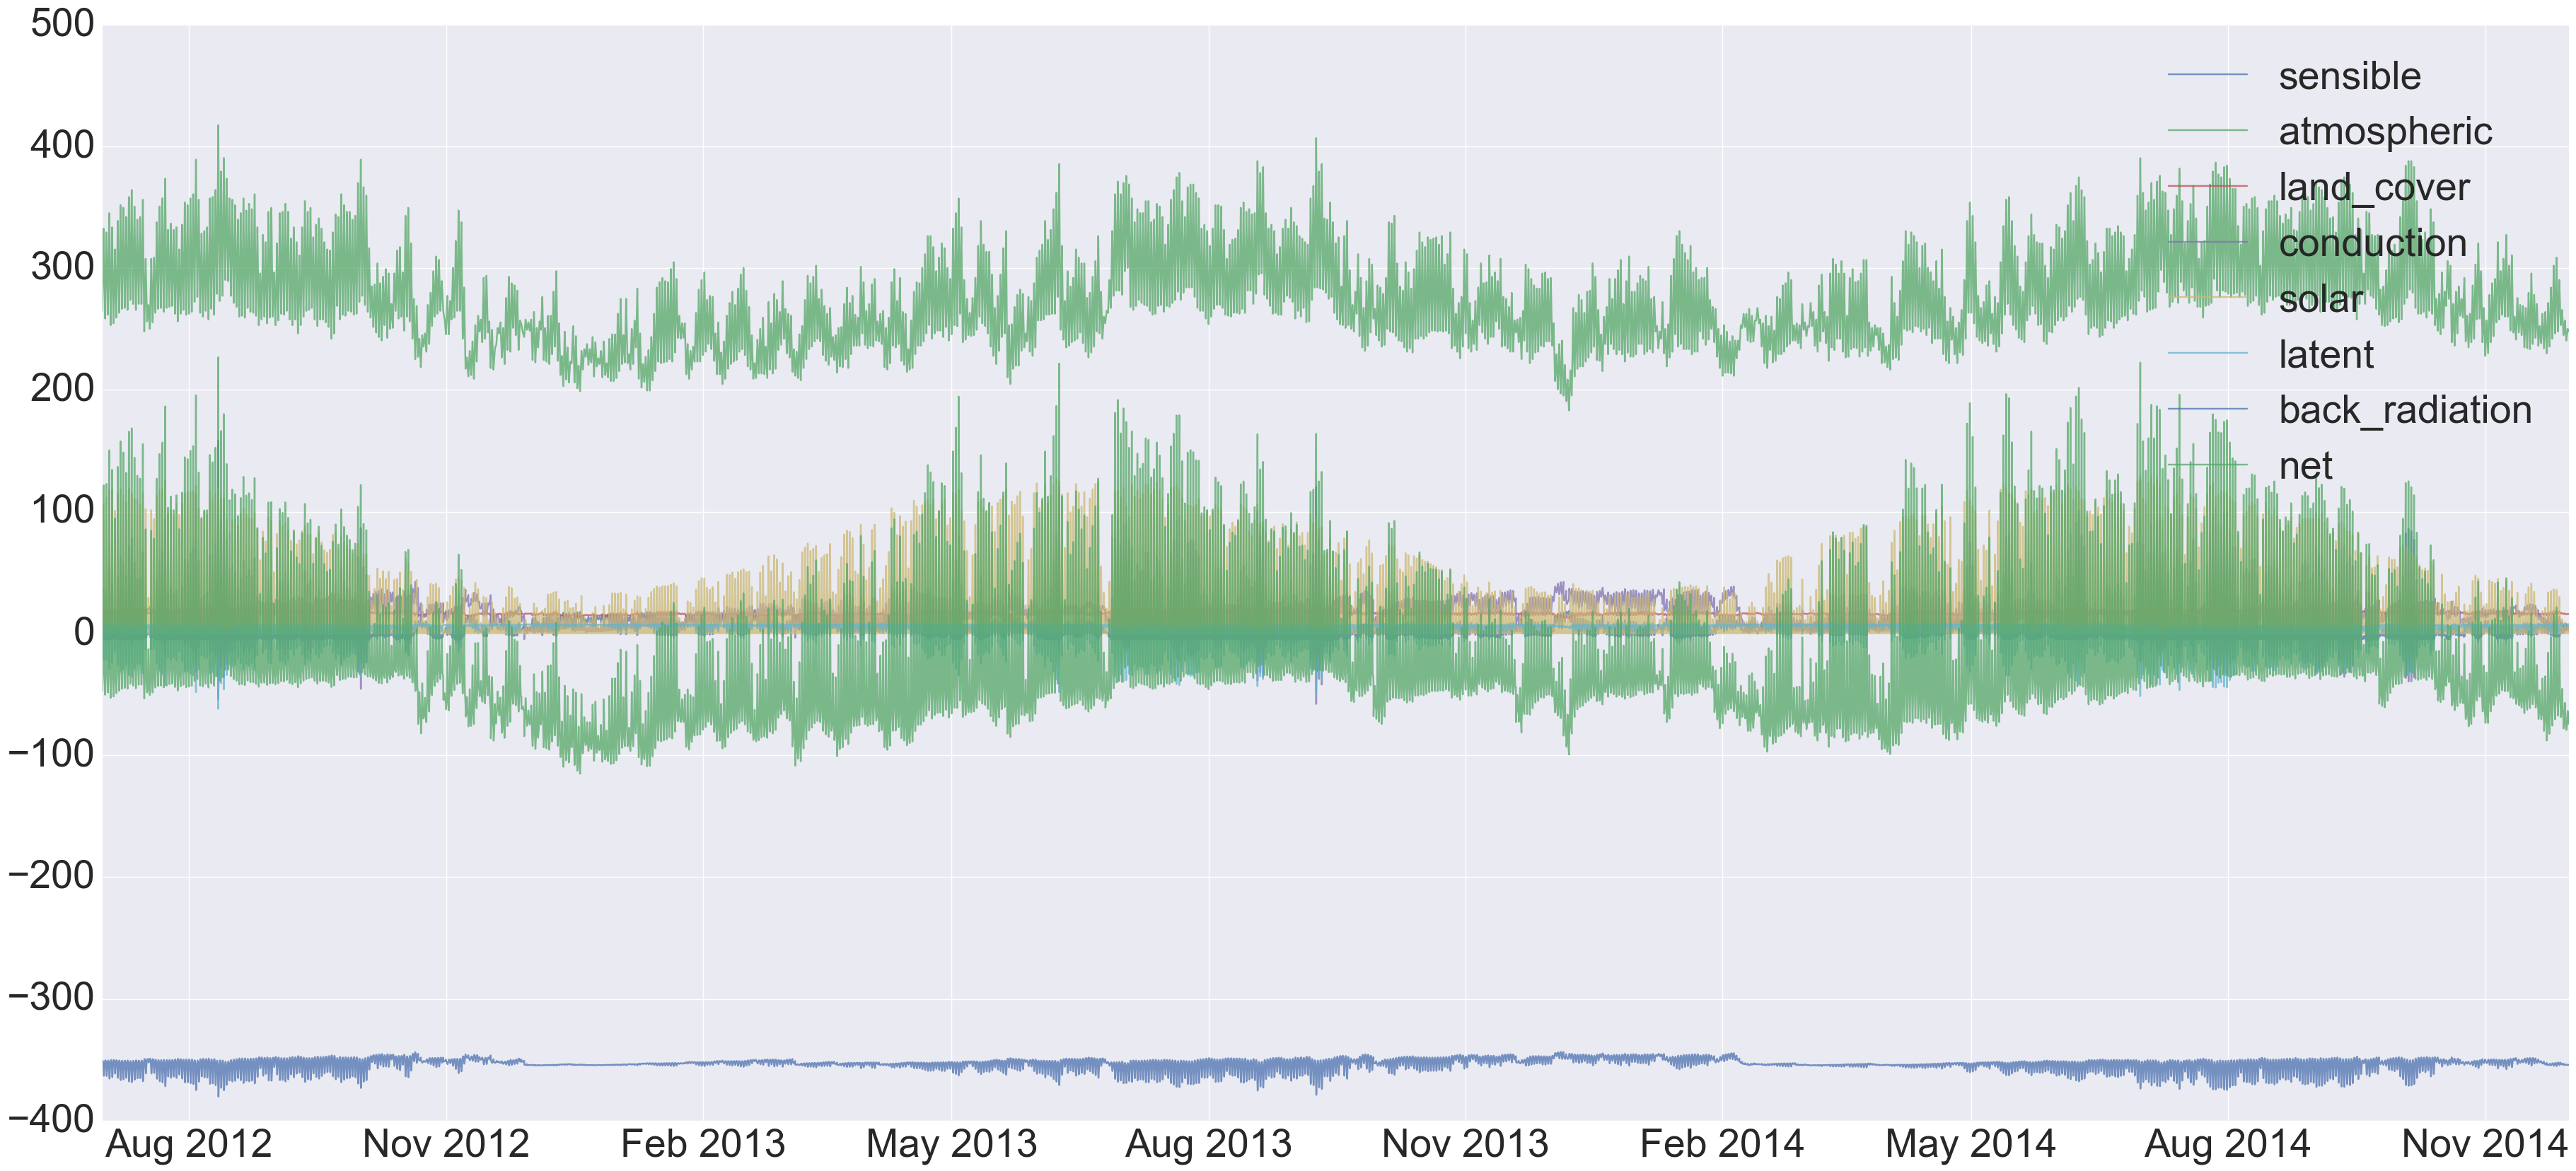

In [6]:
sns.set(font_scale=4)
plt.figure(figsize=(45,20))
temp_data = pickle.load( open(os.path.join(parent_dir,'calibration_data','elder_temperature.p'), "rb" ))

plt.plot(network_temps[1],alpha=.3, linewidth=6,label='Model')
plt.plot(temp_data.temperature,label='Data')
plt.plot(network_airtemp[1].ta,alpha=0.5,label='Air Temp.')
plt.plot(-network_airtemp[1].ppt,label='Precip.')
plt.plot(-hillslope_discharge,label='Hillslope')
plt.plot(timestamps_temperature,11*np.ones(np.shape(timestamps_temperature)),'k')
# plt.plot(Sin/np.mean(Sin),label='Shortwave')
# plt.plot((network_airtemp[1].Sin-10)/10)
# plt.plot(network_airtemp[1].depth)

plt.ylim((-20,40))

# plt.axvspan(start_date, spinup_date, color='gray', alpha=0.1, lw=0)
# plt.axvspan(spinup_date, stop_date, color='white', alpha=0.1, lw=0)
xlim = ['7-2012','12-2014']

plt.xlim(xlim)

plt.legend()

plt.figure()
sns.set(font_scale=4)
plt.figure(figsize=(45,20))
f = fluxes[1].copy()
f['net'] = f.sum(axis=1)
for col in f.columns: 
    plt.plot(f[col],label=col,alpha=0.75)

plt.xlim(xlim)    
plt.legend()


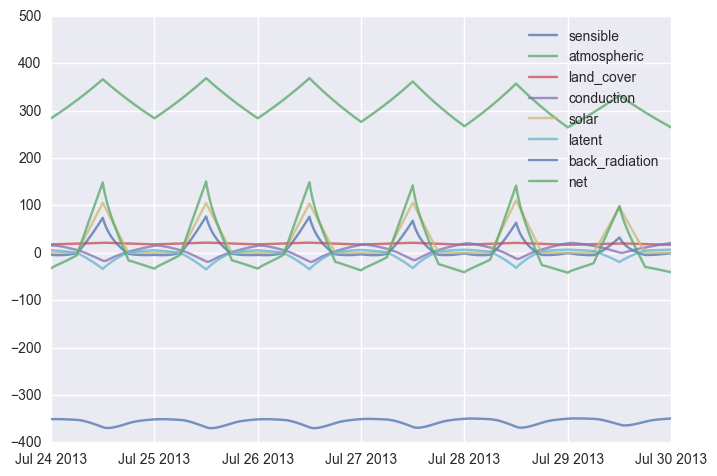

In [7]:
sns.set(font_scale=1)
f = fluxes[1].copy()
f['net'] = f.sum(axis=1)
for col in f.columns: 
    plt.plot(f[col],label=col,alpha=0.75)

plt.xlim(('7-24-2013','7-30-2013'))    
plt.legend()

(0, 60)

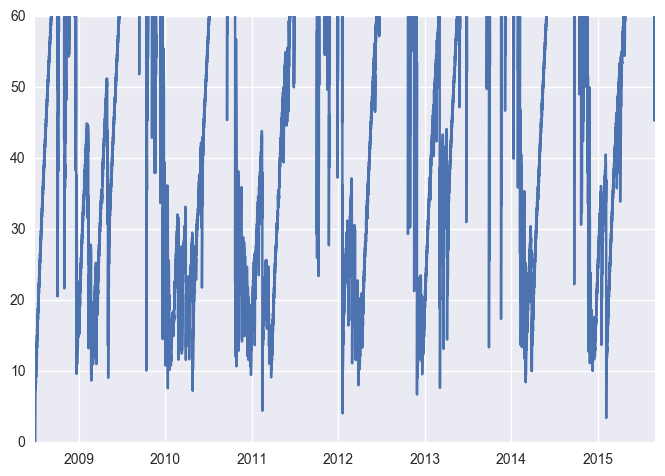

In [8]:
rew_id = 1
length = 0.01*channel_network[rew_id].length
volumetric_discharge = 1.15741e-11*np.array(solved_channel_routing[rew_id][start_date:stop_date].volumetric_discharge.resample(resample_freq_temperature).ffill())
volume = 1e-6*np.array(solved_channel_routing[rew_id][start_date:stop_date].volumes.resample(resample_freq_temperature).interpolate())

angle = 2*np.pi/20
width = np.sqrt(2*volume/np.tan(angle)/length)

cross_sectional_area = volume/length

v = volumetric_discharge/cross_sectional_area
dx = length/100

dt = dx/v

sns.set(font_scale=1)
plt.plot(timestamps_temperature,dt)
plt.ylim((0,60))

In [9]:
temperature_network


{1: <temperature.EulerianWesthoff instance at 0x104369d88>,
 2: <temperature.EulerianWesthoff instance at 0x10441da28>,
 3: <temperature.EulerianWesthoff instance at 0x10441dc68>}

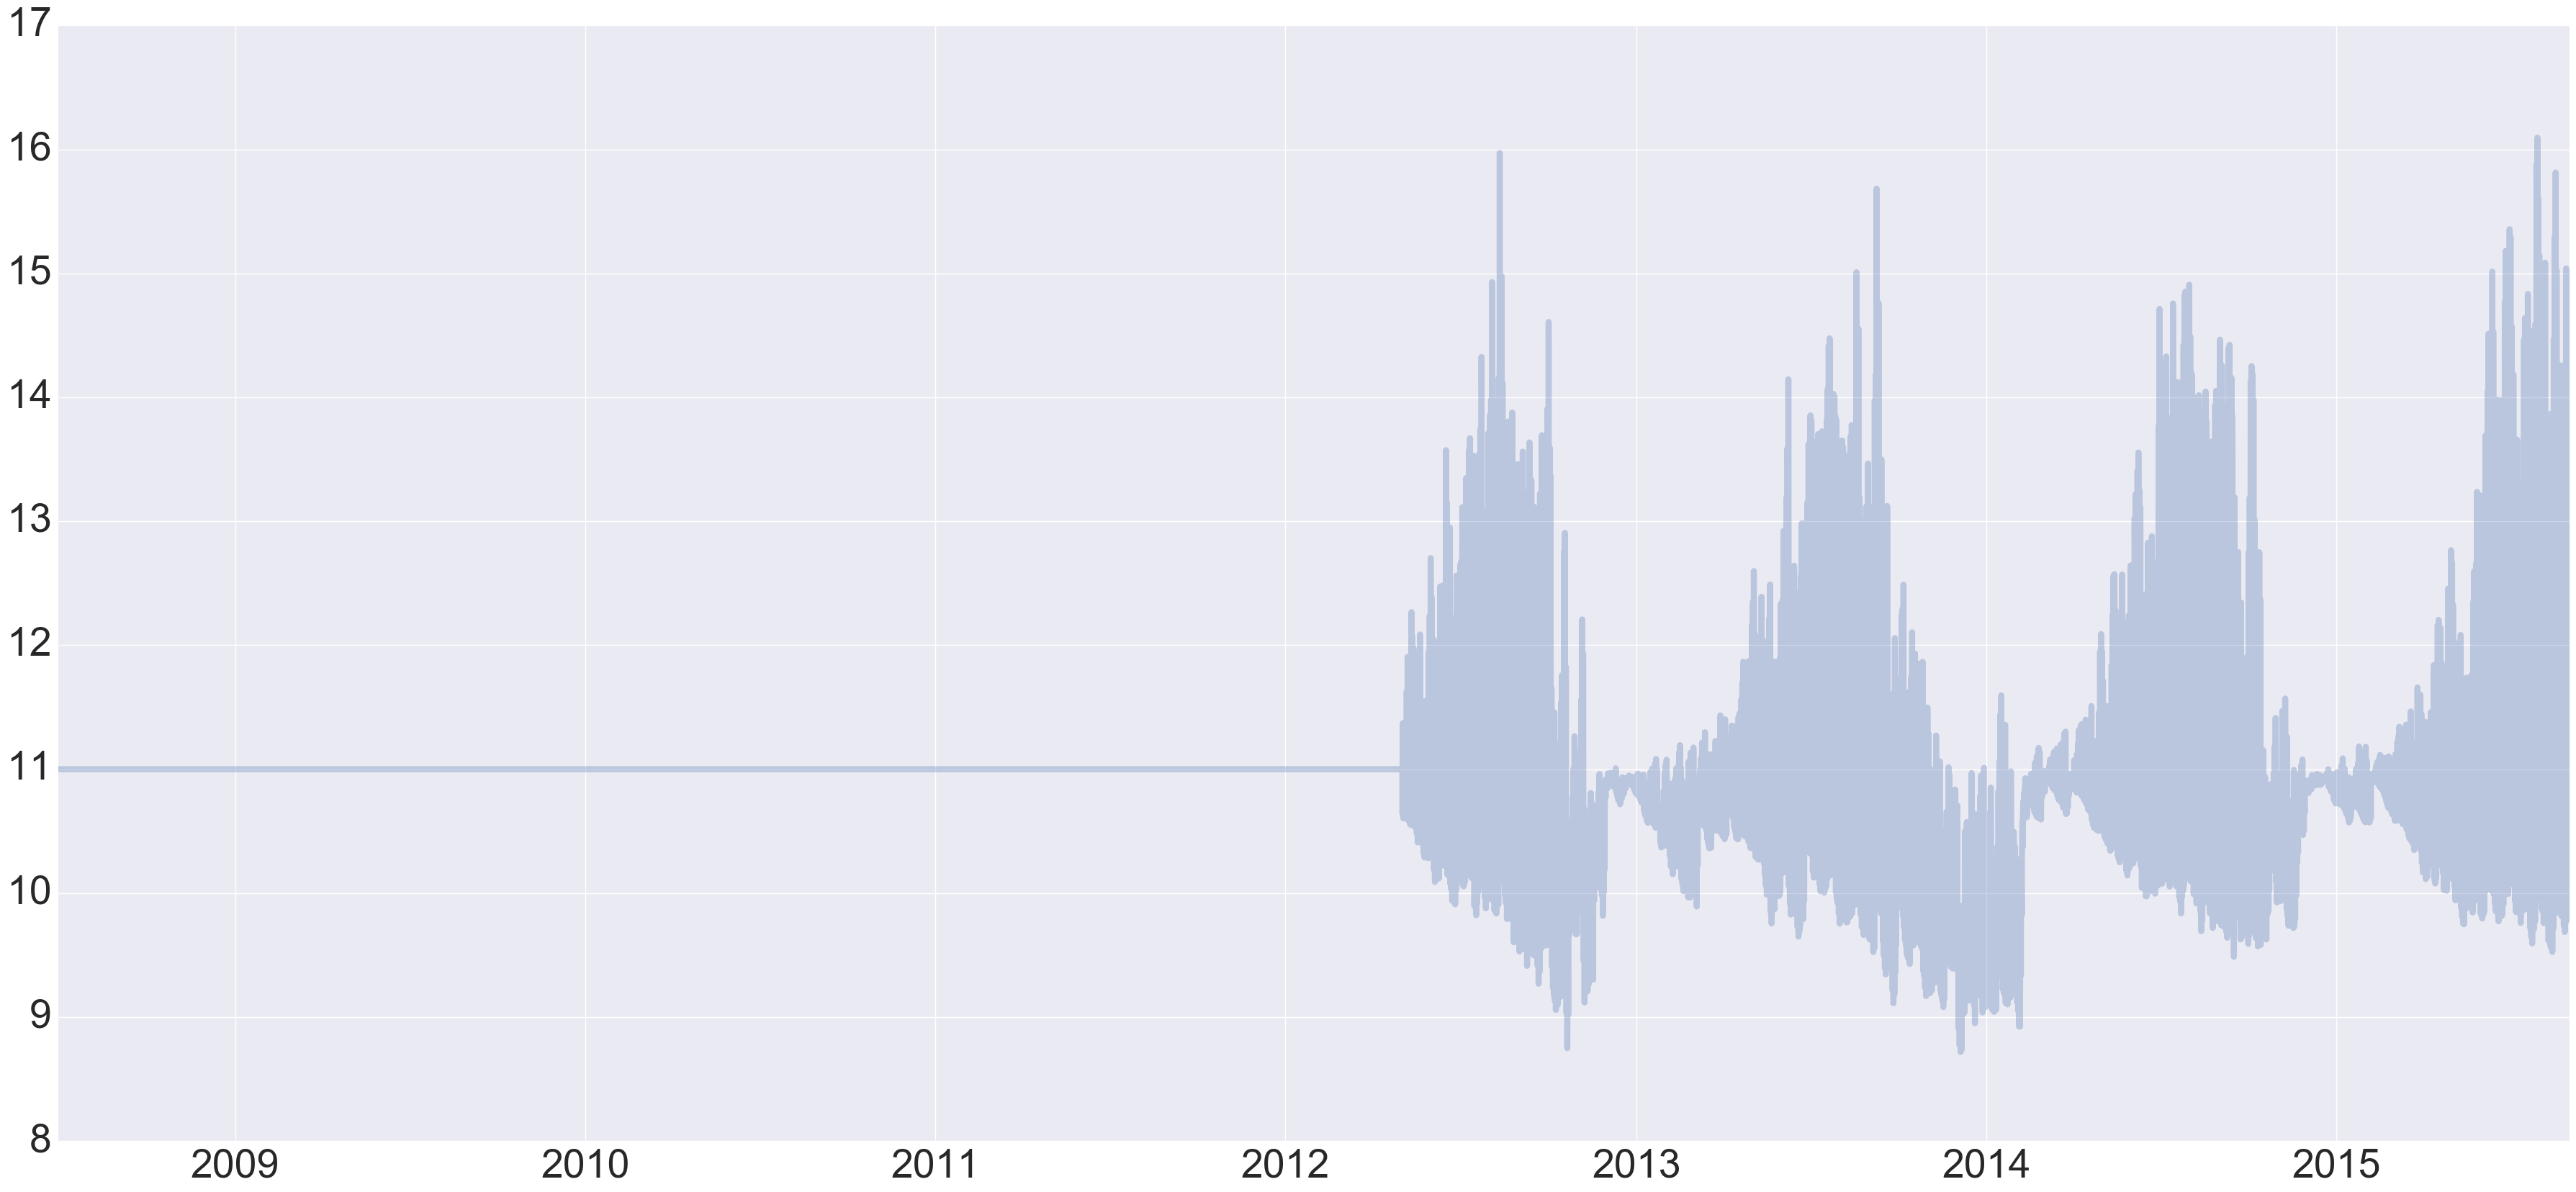

In [10]:
sns.set(font_scale=4)
plt.figure(figsize=(45,20))
temp_data = pickle.load( open(os.path.join(parent_dir,'calibration_data','elder_temperature.p'), "rb" ))

plt.plot(network_temps[1],alpha=.3, linewidth=6,label='Model')